In [10]:
import json
import pandas as pd

#load the jason file
file_path = r"C:\Users\sajad\Downloads\2armed_bandit.json"
with open(file_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head(204)






rt                                           stimulus response  \
0    6946.0  <div style='color:white'>Welcome to our decisi...            
1    1287.0  <div style='color:white'>\n    <div class="slo...            
2    1130.0  <div style='color:white'>After selecting a ban...            
3     520.0  <div style='color:white'>Your goal is to earn ...            
4    1414.0  [<div class="slotmachine" style="position: abs...        0   
..      ...                                                ...      ...   
199     NaN           <div style='color:white'>Score: 63</div>     None   
200  1108.0  [<div class="slotmachine" style="position: abs...        0   
201     NaN           <div style='color:white'>Score: 63</div>     None   
202   610.0  [<div class="slotmachine" style="position: abs...        0   
203     NaN           <div style='color:white'>Score: 64</div>     None   

                 trial_type  trial_index  time_elapsed internal_node_id  \
0    html-keyboard-response            0          6951      0.0-0.0-0.0   
1    html-keyboard-response            1          8241      0.0-0.0-1.0   
2    html-keyboard-response            2          9372      0.0-0.0-2.0   
3    html-keyboard-response            3          9894      0.0-0.0-3.0   
4               html-choice            4         13317      0.0-1.0-0.0   
..                      ...          ...           ...              ...   
199  html-keyboard-response          199        374656     0.0-1.0-1.97   
200             html-choice          200        377776     0.0-1.0-0.98   
201  html-keyboard-response          201        378780     0.0-1.0-1.98   
202             html-choice          202        381398     0.0-1.0-0.99   
203  html-keyboard-response          203        382400     0.0-1.0-1.99   

     bean_trial_duration  bean_duration  \
0                    NaN            NaN   
1                    NaN            NaN   
2                    NaN            NaN   
3                    NaN            NaN   
4                    NaN            NaN   
..                   ...            ...   
199               1000.0         1000.0   
200                  NaN            NaN   
201               1000.0         1000.0   
202                  NaN            NaN   
203               1000.0         1000.0   

                                         bean_stimulus  ...  \
0    <div style='color:white'>Welcome to our decisi...  ...   
1    <div style='color:white'>"\n    <div class="sl...  ...   
2    <div style='color:white'>After selecting a ban...  ...   
3    <div style='color:white'>Your goal is to earn ...  ...   
4                                                  NaN  ...   
..                                                 ...  ...   
199           <div style='color:white'>Score: 63</div>  ...   
200                                                NaN  ...   
201           <div style='color:white'>Score: 63</div>  ...   
202                                                NaN  ...   
203           <div style='color:white'>Score: 64</div>  ...   

                                             bean_text bean_color  \
0    Welcome to our decision-making experiment. In ...      white   
1    "\n    <div class="slotmachine" style="positio...      white   
2    After selecting a bandit, you will receive fee...      white   
3    Your goal is to earn as many points as possibl...      white   
4                                                  NaN        NaN   
..                                                 ...        ...   
199                                          Score: 63      white   
200                                                NaN        NaN   
201                                          Score: 63      white   
202                                                NaN        NaN   
203                                          Score: 64      white   

    bean_correct value                                    bean_html_array  \
0          False   NaN     

In [11]:
import pandas as pd

#keep only the rows from 4 to 204 which are the rows of the actual trials
df = df.iloc[4:204].copy()

#keep only essential columns
df = df[['trial_index', 'response', 'bean_value', 'bean_bandits']]

#rename the columns
df.rename(columns={
    'trial_index': 'trial',
    'response': 'choice',
    'bean_value': 'reward',
    'bean_bandits': 'bandit_info'
    }, inplace=True)

#reset the index
df.reset_index(drop=True, inplace=True)

print(df.head())







   trial choice  reward                                        bandit_info
0      4      0     0.0  [{'color': 'orange', 'value': 0}, {'color': 'b...
1      5   None     NaN                                                NaN
2      6      1     1.0  [{'color': 'orange', 'value': 1}, {'color': 'b...
3      7   None     NaN                                                NaN
4      8      1     1.0  [{'color': 'orange', 'value': 0}, {'color': 'b...


In [12]:
#our one-state env
import numpy as np

class OneStepBanditEnv:
    def __init__(self, p_bandit0 = 0.8,             #probability of getting reward from the first bandit
                 p_bandit1 = 0.2,                   #robability of getting reward from the second bandit
                 reversal_trial = 50,               #changing the probabilities in after the half of the trials
                 n_trials = 100):
        self.p0_init = p_bandit0
        self.p1_init = p_bandit1
        self.reversal_trial = reversal_trial
        self.n_trials = n_trials
        self.trial = 0
        #current probabilities:
        self.p0 = p_bandit0
        self.p1 = p_bandit1
        self.done = False

    def reset(self):
        self.trial = 0
        self.p0 = self.p0_init
        self.p1 = self.p1_init
        self.done = False
        return None             #single-state env, so no real "state" to return
    

    def get_terminal_state(self):
        """
        Getter function for self.done
        """
        return self.done
    
    def get_trial_number(self):
        """
        Getter function for self.trial
        """
        return self.trial
    

    def step(self, action):
        """
        action: 0 or 1 for bandit choice
        returns: reward, done, info
        """
        #revers the probs when in the correct trial
        if self.trial == self.reversal_trial:
            old_p0 = self.p0
            self.p0 = self.p1
            self.p1 = old_p0

        #get reward from chosen bandit
        if action == 0:
            reward = np.random.binomial(1, self.p0)
        elif action== 1:
            reward = np.random.binomial(1, self.p1)
        else:
            raise ValueError("action must be 0 or 1")
        
        self.trial += 1
        terminate_trials = (self.trial >= self.n_trials)      #done after N_trials
        self.done = terminate_trials
        return reward, self.get_terminal_state()
        

In [13]:
def softmax(vals, beta):
    """
    Softmax function for action selection
    vals: The array of action values
    beta: Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
    return: The probabilities of each action, sums up to 1
    """

    """Compute softmax values for each sets of scores in x."""

    result = np.exp(vals * beta) / np.sum(np.exp(vals * beta))

    return result

In [14]:
class BaseAgent:
    def __init__(self, learning_rate = 0.1, inverse_temp = 1.0):
        """
        a base agent for a single-state 2-bandit task
        learning_rate: learning rate
        inverse_temp: inverse temprature
        """
        self.learning_rate = learning_rate
        self.inverse_temp = inverse_temp
        self.Q_table = np.zeros(2)        #store Q for each action(2 actions)

    def get_action_probs(self):
        """
        return softmax probabilities for two bandits
        """
        probs = softmax(self.Q_table, self.inverse_temp)
        return probs
    

    def policy(self):
        """
        choose an action using the softmax policy
        called in simulate()
        """
        probs = self.get_action_probs()
        action = np.random.choice([0,1], p= probs)
        return action
    
    def update_values(self, action, reward):
        """
        update the choosen action values using the Rescorla-Wagner rule
        called in simulate
        """

        rpe = reward - self.Q_table[action]
        self.Q_table[action] += self.learning_rate * rpe

In [15]:
#Thompson Sampling Agent with no decay
#import numpy as np

#class ThompsonSamplingAgentNoDecay(BaseAgent):
#    def __init__(self, alpha0 = 1.0, beta0 = 1.0):
 #       """
  #      alpha0 and beta0: initial Beta prior hyperparamrters
   #     """
    #    super().__init__(alpha = 0.0, beta = 0.0)       #initialize the parent class with dummy alpha and beta since we are not using them
     #   self.alpha0 = alpha0
      #  self.beta0 = beta0
       # self.reset()

#    def reset(self):
#        self.alphas = [self.alpha0, self.alpha0]
 #       self.betas = [self.beta0, self.beta0]
#
 #   def policy(self):
        #Overrides BaseAgent's policy() and returns an action by Thompson sampling from Beta distributions

 #       sample_0 = np.random.beta(self.alphas[0], self.betas[0])
  #      sample_1 = np.random.beta(self.alphas[1], self.betas[1])
   #     return 0 if sample_0 > sample_1 else 1
    
 #   def update_values(self, action, reward):
        #Overrides BaseAgent's update_values() and updates the chosen arm's Beta posterior
        
  #      if reward == 1:
   #         self.alphas[action] += 1
    #    else:
#            self.betas[action] += 1


In [16]:
"""
REWRITING THOMPSON AGENT WITHOUT INHERITANCE
"""
#Thompson Sampling Agent with no decay


class ThompsonSamplingAgentNoDecay():
    def __init__(self, alpha0_arm0 = 1.0, beta0_arm0 = 1.0, alpha0_arm1 = 1.0, beta0_arm1 = 1.0):
        """
        alpha0 and beta0: initial Beta prior hyperparamrters
        """
        self.alphas = [alpha0_arm0, alpha0_arm1]
        self.betas = [beta0_arm0, beta0_arm1]
        self.reset()

    def reset(self):
        self.alphas = [self.alphas[0], self.alphas[1]]
        self.betas = [self.betas[0], self.betas[1]]

    def get_beta_parameters(self):
        """
        Returns beta parameters pairwise for each beta distribution
        """
        bandit0_params = (self.alphas[0], self.betas[0])
        bandit1_params = (self.alphas[1], self.betas[1])
        return bandit0_params, bandit1_params


    def policy(self):
        #sample from each arm's Beta distribution
        sample_0 = np.random.beta(self.alphas[0], self.betas[0])
        sample_1 = np.random.beta(self.alphas[1], self.betas[1])
        return 0 if sample_0 > sample_1 else 1

    def update_values(self, action, reward):
        """
        Overrides BaseAgent's update_values() and updates the chosen arm's Beta posterior
        """

        if reward == 1:
            self.alphas[action] += 1
        else:
            self.betas[action] += 1


In [20]:
#Thompson Sampling Agent with decay
import numpy as np

class ThompsonSamplingAgentDecay():
    def __init__(self, alpha0_arm0 = 1.0, beta0_arm0 = 1.0, alpha0_arm1 = 1.0, beta0_arm1 = 1.0, decay = 0.95):
        """
        alpha0 and beta0: initial Beta prior hyperparamrters
        """
        self.alphas = [alpha0_arm0, alpha0_arm1]
        self.betas = [beta0_arm0, beta0_arm1]
        self.decay = decay
        self.reset()

    def reset(self):
        self.alphas = [self.alphas[0], self.alphas[1]]
        self.betas = [self.betas[0], self.betas[1]]

    def get_beta_parameters(self):
        """
        Returns beta parameters pairwise for each beta distribution
        """
        bandit0_params = (self.alphas[0], self.betas[0])
        bandit1_params = (self.alphas[1], self.betas[1])
        return bandit0_params, bandit1_params


    def policy(self):
        #Overrides BaseAgent's policy() and returns an action by Thompson sampling from Beta distributions

        sample_0 = np.random.beta(self.alphas[0], self.betas[0])
        sample_1 = np.random.beta(self.alphas[1], self.betas[1])
        return 0 if sample_0 > sample_1 else 1
    
    def update_values(self, action, reward):
        #Overrides BaseAgent's update_values() and updates the chosen arm's Beta posterior

        #decay the existing posterior values
        self.alphas[action] *= self.decay
        self.betas[action] *= self.decay

        #update the chosen arm's posterior
        if reward == 1:
            self.alphas[action] += 1
        else:
            self.betas[action] += 1



In [21]:
def simulate(env: OneStepBanditEnv, agent):
    """
    Simulate with given agent
    :param env: environment
    :param agent: given agent
    :param trials: number of trials
    :return: simulated task data as a dataframe
    """

    env.reset()
    task_data = {}
    terminal = env.get_terminal_state()

    while terminal == False:
        # first stage choice
        trial_info = {}

        action = agent.policy()
        reward, terminal = env.step(action)
        agent.update_values(action, reward)
        bandit0_params, bandit1_params = agent.get_beta_parameters()

        #Data collection
        trial_info["action"] = action
        trial_info["reward"] = reward
        trial_info["mean0"] = bandit0_params[0] / (bandit0_params[0] + bandit0_params[1])
        trial_info["mean1"] = bandit1_params[0] / (bandit1_params[0] + bandit1_params[1])
        trial_info["alpha0"] = bandit0_params[0] 
        trial_info["alpha1"] = bandit1_params[0] 
        trial_info["beta0"] = bandit0_params[1]
        trial_info["beta1"] = bandit1_params[1]
        task_data[env.get_trial_number()] = trial_info


    return pd.DataFrame.from_dict(task_data, orient='index')

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import beta

np.random.seed(0)
env = OneStepBanditEnv()

agent_thompson_nodecay = ThompsonSamplingAgentNoDecay()
data_thompson_nodecay = simulate(env, agent_thompson_nodecay)

agent_thompson_decay = ThompsonSamplingAgentDecay()
data_thompson_decay = simulate(env, agent_thompson_decay)

print(data_thompson_nodecay)
print(data_thompson_decay)

     action  reward     mean0     mean1  alpha0  alpha1  beta0  beta1
1         0       1  0.666667  0.500000     2.0     1.0    1.0    1.0
2         0       0  0.500000  0.500000     2.0     1.0    2.0    1.0
3         0       1  0.600000  0.500000     3.0     1.0    2.0    1.0
4         0       1  0.666667  0.500000     4.0     1.0    2.0    1.0
5         0       1  0.714286  0.500000     5.0     1.0    2.0    1.0
..      ...     ...       ...       ...     ...     ...    ...    ...
96        1       1  0.546667  0.720000    41.0    18.0   34.0    7.0
97        0       1  0.552632  0.720000    42.0    18.0   34.0    7.0
98        1       1  0.552632  0.730769    42.0    19.0   34.0    7.0
99        1       1  0.552632  0.740741    42.0    20.0   34.0    7.0
100       1       1  0.552632  0.750000    42.0    21.0   34.0    7.0

[100 rows x 8 columns]
     action  reward     mean0     mean1   alpha0     alpha1      beta0  \
1         1       0  0.500000  0.327586  1.00000   0.950000   

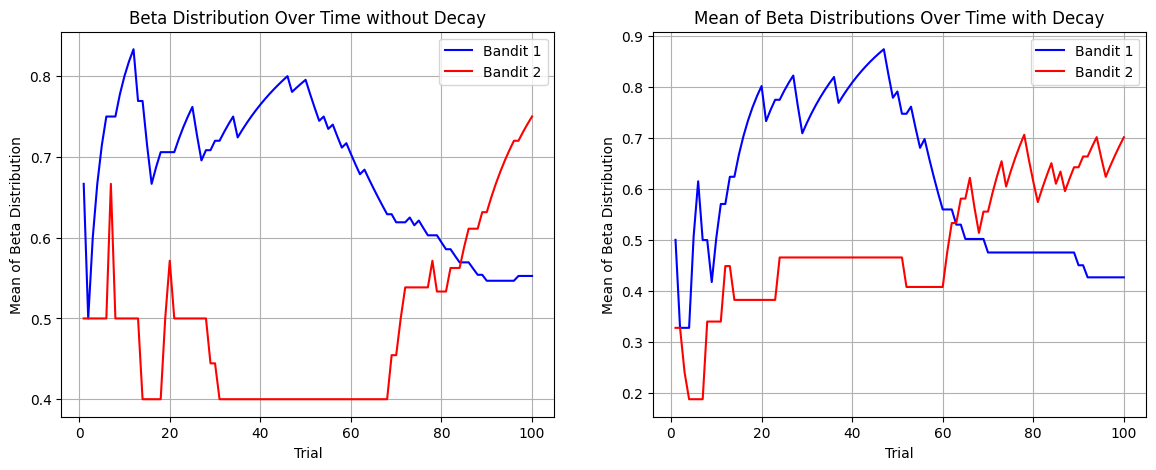

In [35]:
"""
Plotting Mean of Beta Distribution Over Time

"""

plt.figure(figsize=(14, 5))
# Plot for NoDecay agent
plt.subplot(1, 2, 1)
plt.plot(range(1, len(data_thompson_nodecay["mean0"]) + 1), data_thompson_nodecay["mean0"], linestyle='-', color='blue', label="Bandit 1")
plt.plot(range(1, len(data_thompson_nodecay["mean1"]) + 1), data_thompson_nodecay["mean1"], linestyle='-', color='red', label="Bandit 2")

plt.xlabel("Trial")
plt.ylabel("Mean of Beta Distribution")
plt.title("Beta Distribution Over Time without Decay")
plt.legend()
plt.grid()

# Plot for Decay agent
plt.subplot(1, 2, 2)
plt.plot(range(1, len(data_thompson_decay["mean0"]) + 1), data_thompson_decay["mean0"], linestyle='-', color='blue', label="Bandit 1")
plt.plot(range(1, len(data_thompson_decay["mean1"]) + 1), data_thompson_decay["mean1"], linestyle='-', color='red', label="Bandit 2")

plt.xlabel("Trial")
plt.ylabel("Mean of Beta Distribution")
plt.title("Mean of Beta Distributions Over Time with Decay")
plt.legend()
plt.grid()



# Show plot
plt.show()

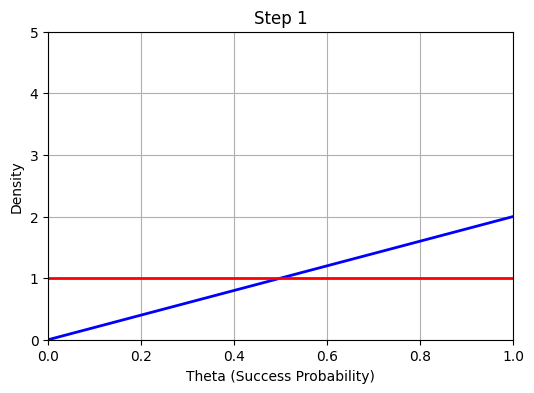

In [36]:
"""
Animation of Beta Distributions Over Time
WITHOUT DECAY

"""

import matplotlib.animation as animation
from IPython.display import HTML


# X-axis values for Beta distribution
x = np.linspace(0, 1, 1000)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
line1, = ax.plot([], [], 'b-', lw=2)
line2, = ax.plot([], [], 'b-', lw=2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 5)
ax.set_xlabel("Theta (Success Probability)")
ax.set_ylabel("Density")
ax.set_title("Evolution of Beta Distribution without decay")
ax.grid()

# Update function for animation
def update(frame):    
    # Compute Beta distribution
    y0 = beta.pdf(x, data_thompson_nodecay["alpha0"][frame+1], data_thompson_nodecay["beta0"][frame+1])
    y1 = beta.pdf(x, data_thompson_nodecay["alpha1"][frame+1], data_thompson_nodecay["beta1"][frame+1])

    # Update plot
    line1.set_data(x, y0)
    line1.set_color("blue")
    line2.set_data(x, y1)
    line2.set_color("red")
    ax.set_title(f"Step {frame+1}")
    return line1, line2

# Create animation
ani = animation.FuncAnimation(fig, update, frames=env.get_trial_number(), blit=False, interval=200)

HTML(ani.to_jshtml())

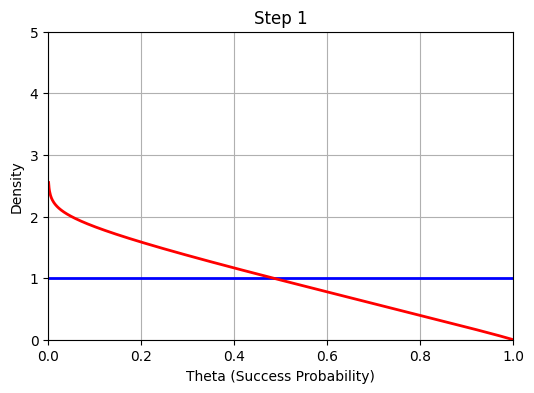

In [37]:
"""
Animation of Beta Distributions Over Time
WITH DECAY

""" 

# X-axis values for Beta distribution
x = np.linspace(0, 1, 1000)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
line1, = ax.plot([], [], 'b-', lw=2)
line2, = ax.plot([], [], 'b-', lw=2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 5)
ax.set_xlabel("Theta (Success Probability)")
ax.set_ylabel("Density")
ax.set_title("Evolution of Beta Distribution with decay")
ax.grid()

# Update function for animation
def update(frame):    
    # Compute Beta distribution
    y0 = beta.pdf(x, data_thompson_decay["alpha0"][frame+1], data_thompson_decay["beta0"][frame+1])
    y1 = beta.pdf(x, data_thompson_decay["alpha1"][frame+1], data_thompson_decay["beta1"][frame+1])

    # Update plot
    line1.set_data(x, y0)
    line1.set_color("blue")
    line2.set_data(x, y1)
    line2.set_color("red")
    ax.set_title(f"Step {frame+1}")
    return line1, line2

# Create animation
ani = animation.FuncAnimation(fig, update, frames=env.get_trial_number(), blit=False, interval=200)

HTML(ani.to_jshtml())

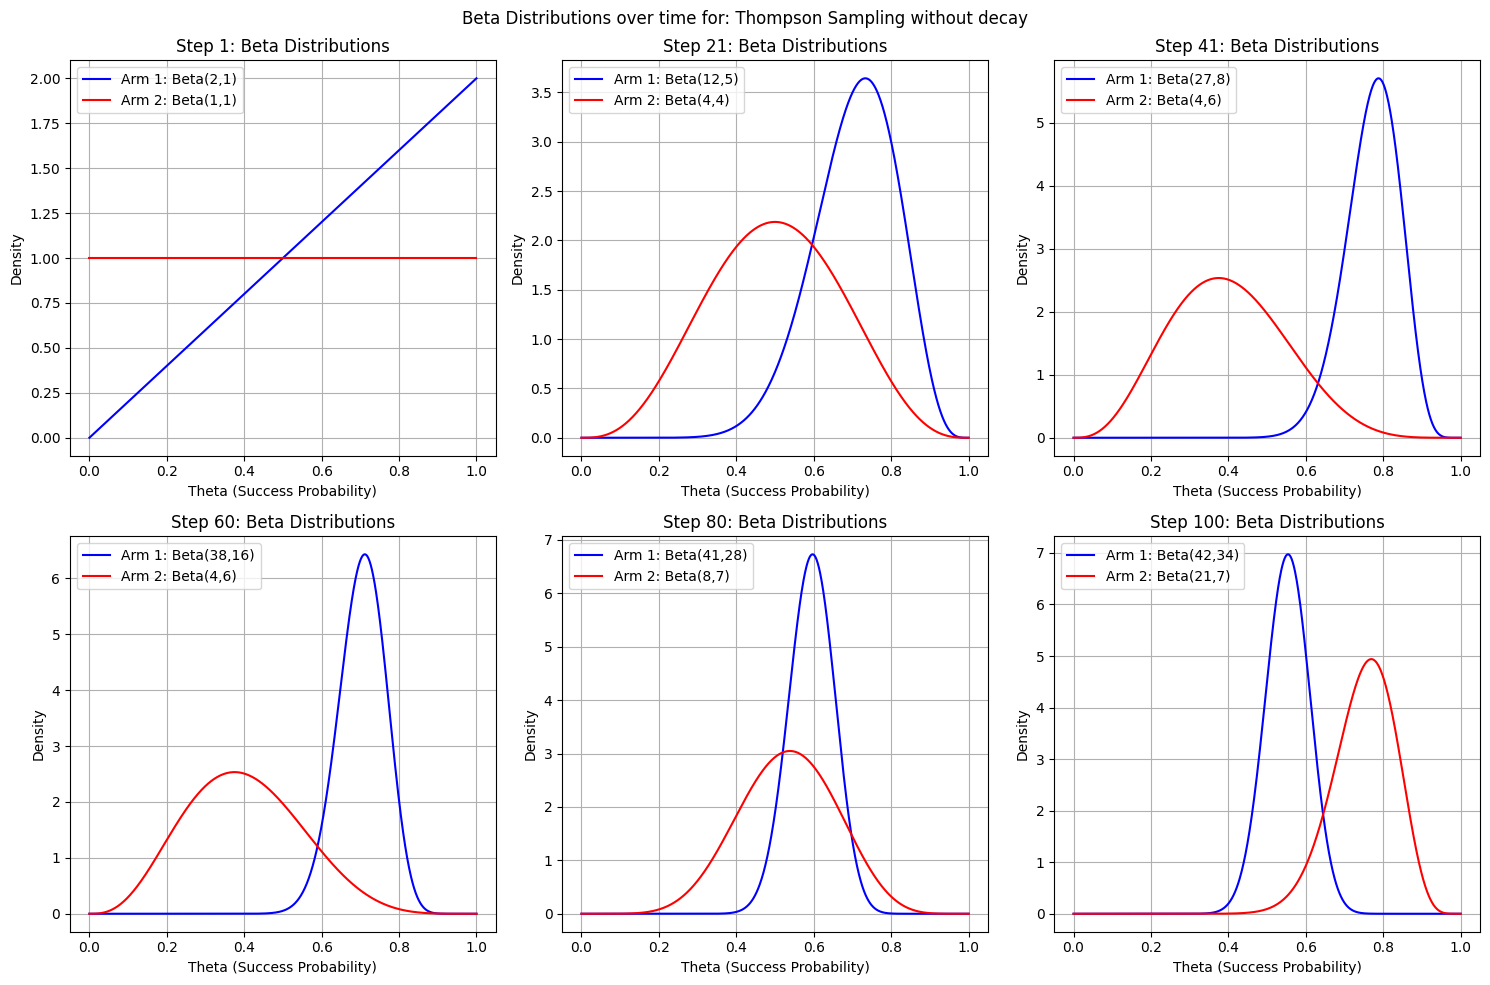

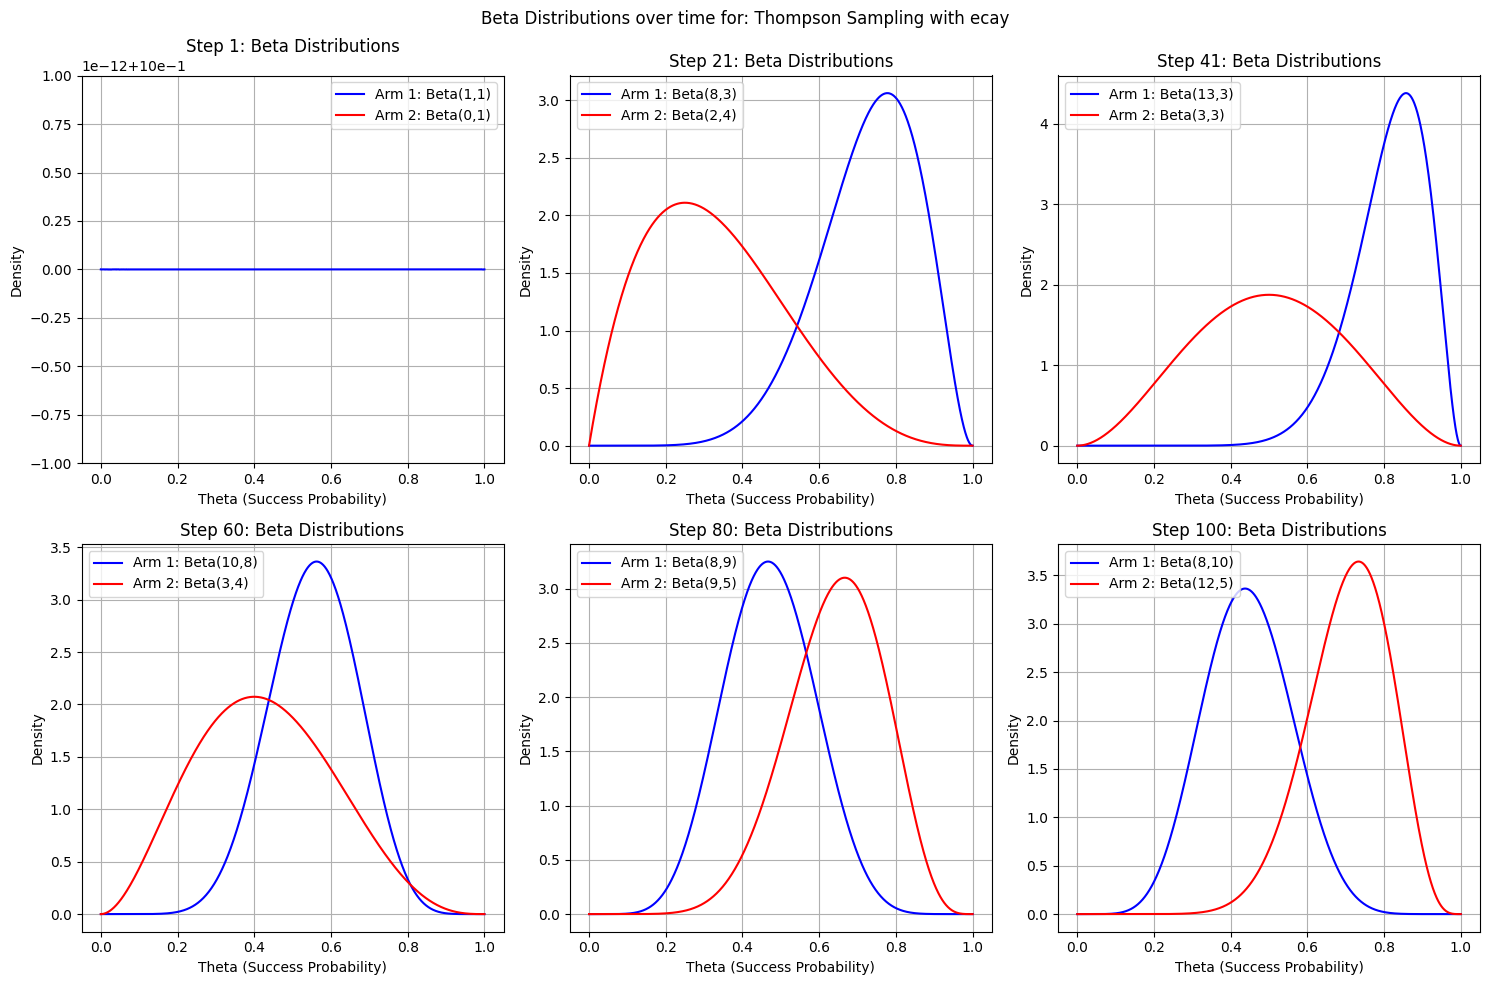

In [38]:
"""
Beta Distributions at different time steps

"""
import matplotlib.animation as animation
from IPython.display import HTML

def plot_overTime(data, model):
    # X-axis values for Beta distribution
    x = np.linspace(0, 1, 1000)

    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
    fig.suptitle(f"Beta Distributions over time for: {model}")
    axes = axes.flatten()  # Flatten axes array for easy indexing


    for i, trial in enumerate(np.linspace(1, env.get_trial_number(), 6)):
        trial = int(np.round(trial))
        #get params
        alpha0 = int(data["alpha0"][trial])
        alpha1 = int(data["alpha1"][trial])
        beta0 = int(data["beta0"][trial])
        beta1 = int(data["beta1"][trial])

        # Compute Beta distribution
        y0 = beta.pdf(x, alpha0, beta0)
        y1 = beta.pdf(x, alpha1, beta1)
        
        # Plot the Beta distributions for arm 1 and arm 2 at time t
        axes[i].plot(x, y0, label=f"Arm 1: Beta({alpha0},{beta0})", color='blue')
        axes[i].plot(x, y1, label=f"Arm 2: Beta({alpha1},{beta1})", color='red')
        
        # Title and labels
        axes[i].set_title(f"Step {trial}: Beta Distributions")
        axes[i].set_xlabel("Theta (Success Probability)")
        axes[i].set_ylabel("Density")
        axes[i].legend()
        axes[i].grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_overTime(data_thompson_nodecay,"Thompson Sampling without decay")
plot_overTime(data_thompson_decay,"Thompson Sampling with ecay")


In [23]:
def run_simulation(n_participants = 50, n_trials = 100, random_seed = 42):
    """
    Example driver function to create many synthetic participants
    from each TS agent (with or without decay), each with random parameters.
    
    :param n_participants: how many participants to simulate PER agent class
    :param n_trials: number of trials in OneStepBanditEnv
    :param random_seed: seed for reproducibility
    :return: A single DataFrame with all simulation data
    """
    np.random.seed(random_seed)

    df_surrogated = []
    #simulate from TS without decay
    for participant_idx in range(n_participants):
        
        #create a new env for each participant
        env = OneStepBanditEnv(n_trials= n_trials)

        #create a new agent for each participant
        no_decay_agent = ThompsonSamplingAgentNoDecay(alpha0_arm0 = np.random.randint(1, 5),
                                                        beta0_arm0 = np.random.randint(1, 5),
                                                        alpha0_arm1 = np.random.randint(1, 5),
                                                        beta0_arm1 = np.random.randint(1, 5))
        

        #run the simulation
        df_participant = simulate(env, no_decay_agent)

        #add participant ID
        df_participant["participant_id"] = participant_idx
        df_participant["model_name"] = "TS_no_decay"
        df_participant["true_alpha0"] = no_decay_agent.alphas[0]
        df_participant["true_beta0"] = no_decay_agent.betas[0]
        df_participant["true_alpha1"] = no_decay_agent.alphas[1]
        df_participant["true_beta1"] = no_decay_agent.betas[1]
        #append to list
        df_surrogated.append(df_participant)

    #simulate from TS with decay
    for participant_idx in range(n_participants):
        #create a new env for each participant
        env = OneStepBanditEnv(n_trials= n_trials)

        #create a new agent for each participant
        decay_agent = ThompsonSamplingAgentDecay(alpha0_arm0 = np.random.randint(1, 5),
                                                 beta0_arm0 = np.random.randint(1, 5),
                                                 alpha0_arm1 = np.random.randint(1, 5),
                                                 beta0_arm1 = np.random.randint(1, 5),
                                                 decay = np.random.uniform(0.9, 0.99))

        #run the simulation
        df_participant = simulate(env, decay_agent)

        #add participant ID
        df_participant["participant_id"] = participant_idx
        df_participant["model_name"] = "TS_decay"
        df_participant["true_alpha0"] = decay_agent.alphas[0]
        df_participant["true_beta0"] = decay_agent.betas[0]
        df_participant["true_alpha1"] = decay_agent.alphas[1]
        df_participant["true_beta1"] = decay_agent.betas[1]
        df_participant["true_decay"] = decay_agent.decay
        #append to list
        df_surrogated.append(df_participant)

    #combine all dataframes into one
    df_surrogated = pd.concat(df_surrogated)

    return df_surrogated
        
    
df_test = run_simulation(n_participants=2, n_trials=5, random_seed=123)
print(df_test)

   action  reward     mean0     mean1    alpha0    alpha1     beta0     beta1  \
1       0       1  0.666667  0.500000  4.000000  3.000000  2.000000  3.000000   
2       0       0  0.571429  0.500000  4.000000  3.000000  3.000000  3.000000   
3       0       1  0.625000  0.500000  5.000000  3.000000  3.000000  3.000000   
4       0       1  0.666667  0.500000  6.000000  3.000000  3.000000  3.000000   
5       0       1  0.700000  0.500000  7.000000  3.000000  3.000000  3.000000   
1       0       1  0.666667  0.666667  2.000000  2.000000  1.000000  1.000000   
2       1       0  0.666667  0.500000  2.000000  2.000000  1.000000  2.000000   
3       0       1  0.750000  0.500000  3.000000  2.000000  1.000000  2.000000   
4       0       1  0.800000  0.500000  4.000000  2.000000  1.000000  2.000000   
5       0       1  0.833333  0.500000  5.000000  2.000000  1.000000  2.000000   
1       0       1  0.628387  0.250000  4.728129  1.000000  2.796097  3.000000   
2       0       0  0.549965 

In [25]:
import numpy as np
from scipy.stats import beta

def compute_log_likelihood_TS(data, alpha0, beta0, alpha1, beta1, decay=None, num_samples=1000):
    """
    computing log-likelihood of observed choices

    alpha0, beta0: Beta parameters for arm 0
    alpha1, beta1: Beta parameters for arm 1
    decay: decay factor (only for surrogate data with decay)
    - num_samples: Number of Monte Carlo samples for estimating choice probabilities

    returns log-likelihood
    """
    log_likelihood = 0
    a0, b0 = alpha0, beta0
    a1, b1 = alpha1, beta1

    for _, row in data.iterrows():

        #sample from beta distributions
        samples_0 = beta.rvs(a0, b0, size=num_samples) # monte carlo sampling for arm 0
        samples_1 = beta.rvs(a1, b1, size=num_samples) # monte carlo sampling for arm 1

        #compute choice probability
        prob_0 = np.mean(samples_0 > samples_1)  # arm 0
        prob_1 = 1 - prob_0  # arm 1

        #get observed action and reward
        action = row['action']
        reward = row['reward']

        #compute choice log-likelihood
        if decay is not None:
            if action == 0:
                a0 *= decay
                b0 *= decay
            else:
                a1 *= decay
                b1 *= decay


        if action == 0:
            a0 += reward
            b0 += 1 - reward
            log_likelihood += np.log(prob_0 + 1e-10)
        else:
            a1 += reward
            b1 += 1 - reward
            log_likelihood += np.log(prob_1 + 1e-10)

        #apply decay if model includes it
        #if decay is not None:
        #    a0, b0 = decay * a0, decay * b0
        #    a1, b1 = decay * a1, decay * b1

    return log_likelihood


